In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Subset, ChainDataset, DataLoader, random_split
import torch.nn.functional as F

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

import pandas as pd
import pickle
import math
import random

import HSIC
import matplotlib.pyplot as plt
import numpy as np
import func
import torchy

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

%matplotlib widget

In [2]:
# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms to apply to each image
transf = transforms.Compose([ #transforms.Resize(227),      # Resizes short size of the PIL image to 256
                              transforms.CenterCrop(224),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
                              transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                              transforms.Normalize(means,stds) # Normalizes tensor with mean and standard deviation
])

data_root = 'Data/PACS/'

domain_mapping = {'photo':0, 'art_painting':1, 'cartoon':2, 'sketch':3}

datasets = {}
for name in os.listdir(data_root):
    
    if not name[0] == '.':
        dataset = torchvision.datasets.ImageFolder(data_root+name, transform=transf)

        datasets[name] = torchy.AddDomain(dataset, domain_mapping[name])
        print(f"Added :{name}, length: {len(datasets[name])}")
    
# Check dataset sizes
# print(f"Clipart Dataset: {len(clipart_dataset)}, classes: {len(clipart_dataset.classes)}")
# print(f"Quickdraw Dataset: {len(qd_dataset)}, classes: {len(qd_dataset.classes)}")
# # print(f"Cartoon Dataset: {len(cartoon_dataset)}")
# print(f"Sketch Dataset: {len(sketch_dataset)}, classes: {len(sketch_dataset.classes)}")

Added :cartoon, length: 2344
Added :art_painting, length: 2048
Added :photo, length: 1670
Added :sketch, length: 3929


Validation on trainingset split
Testing on photo
Training on ['art_painting', 'cartoon', 'sketch'], no HSIC
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


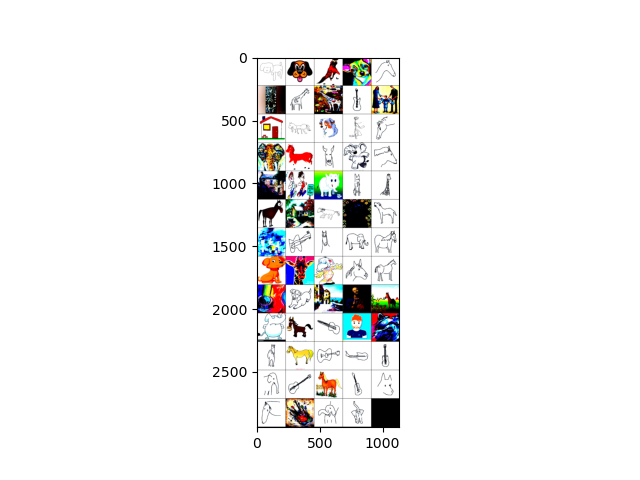

Label: tensor([0, 0, 4, 0, 2, 3, 2, 2, 3, 6, 5, 4, 0, 6, 4, 1, 4, 4, 1, 4, 5, 6, 1, 0,
        2, 4, 5, 4, 0, 0, 5, 3, 4, 1, 4, 0, 2, 1, 4, 4, 3, 0, 5, 6, 4, 1, 4, 3,
        6, 0, 4, 4, 3, 3, 3, 1, 3, 4, 3, 0, 4, 3, 1, 1])


In [3]:
NUM_CLASSES = 7      # 7 classes for each domain: 'dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'
DOMAIN_NAMES = ['photo', 'art_painting', 'cartoon', 'sketch']
CLASSES_NAMES = ['Dog', 'Elephant', 'Giraffe', 'Guitar', 'Horse', 'House', 'Person']
domain_mapping = {'photo':0, 'art_painting':1, 'cartoon':2, 'sketch':3}
batch_size = 64
PATH = 'saved_model.pth'

criterion = nn.CrossEntropyLoss()


lambd = 1
i = 0

# train_names = [DOMAIN_NAMES[1]]
# valid_name = DOMAIN_NAMES[2]
# test_name = DOMAIN_NAMES[0]
# hsic_name =  DOMAIN_NAMES[3]

train_names = DOMAIN_NAMES[1:]
valid_name = 'split'
test_name = DOMAIN_NAMES[0]
hsic_name =  None

train_loader, valid_loader, test_loader, HSIC_loader  = torchy.get_image_loaders(datasets,
                                                                           batch_size,
                                                                           train_names,
                                                                           hsic_name,
                                                                           valid_name,
                                                                           test_name)


# Display image and label.
train_features, train_labels, _ = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = train_features
plt.imshow(torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0))
plt.show()
print(f"Label: {train_labels}")

In [4]:
    
acc_list = []                          
min_valid_loss = 1000
for lr in [0.02, 0.001]:
    
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc1 = nn.Linear(512, 7)
    
    writer= SummaryWriter(f'runs/test_vis')
    optimizer = optim.Adam(resnet18.parameters(), lr=lr)
    min_valid_loss = func.train(resnet18, criterion, optimizer, train_loader,
                                    valid_loader=valid_loader,
                                    epochs=20,
                                    HSIC_loader=HSIC_loader,
                                    lambd=lambd,
                                    writer=writer,
                                    min_valid_loss = min_valid_loss)
    writer.close()
    

KeyboardInterrupt: 